# Bayesian NN


CAN BE DELETED

TODOs
- then test with curriculum


    

# Useful Links
- cifar ex https://github.com/tensorflow/probability/blob/80cc5cb33dfe04cb998bfe27ad3680a7a116d8b1/tensorflow_probability/examples/cifar10_bnn.py
- uses resnet https://github.com/tensorflow/probability/blob/80cc5cb33dfe04cb998bfe27ad3680a7a116d8b1/tensorflow_probability/examples/models/bayesian_resnet.py
- http://krasserm.github.io/2019/03/14/bayesian-neural-networks/
- https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py





In [7]:
from epitome.constants import *
from epitome.models import *
from epitome.generators import *
from epitome.functions import *
from epitome.viz import *
from sklearn.metrics import roc_curve, auc
assert(tf.executing_eagerly())
import tensorflow_probability as tfp
import yaml

In [8]:
# load in user paths
# TODO: make a config file with data_path (downloaded from bin/download_deepsea_data.py) 
# and feature_name_file (at data/feature_name)
# My config.yml looks like:
# data_path: /data/akmorrow/epitome_data/numpy_data/
# feature_name_file: /home/eecs/akmorrow/epitome/data/feature_name

with open('/home/eecs/akmorrow/epitome/config.yml') as f:
    config = yaml.safe_load(f)
    
train_data, valid_data, test_data = load_deepsea_label_data(config["data_path"])
data = {Dataset.TRAIN: train_data, Dataset.VALID: valid_data, Dataset.TEST: test_data}
print(data[Dataset.TRAIN].shape, data[Dataset.VALID].shape, data[Dataset.TEST].shape)

(919, 2200000) (919, 4000) (919, 227512)


## Plot Data Matrix

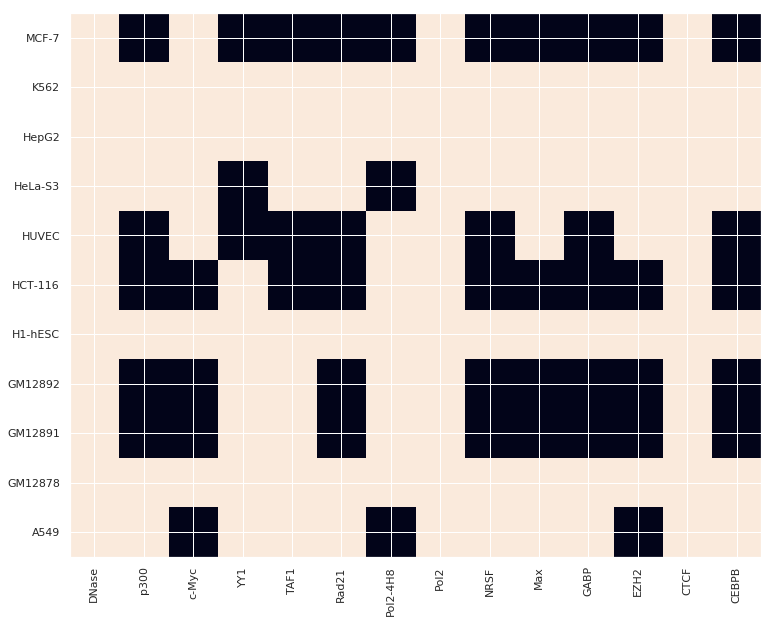

In [9]:
# matrix, cellmap, assaymap = get_assays_from_feature_file(eligible_assays = ['DNase','CTCF'],
#                                   eligible_cells = None)

matrix, cellmap, assaymap = get_assays_from_feature_file(eligible_assays = None,
                                  eligible_cells = None, min_cells_per_assay =6, 
                                                         min_assays_per_cell=7)

nv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=Label.UNK.value)

In [12]:
mlp_model = VLP(data,
        [],
        matrix,
        assaymap,
        cellmap,
        shuffle_size=2, 
        batch_size=64)

mlp_model.train(4000)

results = mlp_model.test(10000)
results

I0730 09:15:04.603674 139858324326144 models.py:625] Starting Training


eval cell types ['MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549']
using ['MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.TRAIN
using ['MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HCT-116', 'H1-hESC', 'GM12892', 'GM12891', 'GM12878', 'A549'] as labels for mode Dataset.VALID
using [] as labels for mode Dataset.TEST
Error: no data, local variable 'x' referenced before assignment


I0730 09:15:08.214840 139858324326144 models.py:647] 0 tf.Tensor(0.05233644, shape=(), dtype=float32)tf.Tensor(0.05233644, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)
I0730 09:16:20.435626 139858324326144 models.py:647] 1000 tf.Tensor(0.006751633, shape=(), dtype=float32)tf.Tensor(0.006751633, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)
I0730 09:17:32.695755 139858324326144 models.py:647] 2000 tf.Tensor(0.0002807859, shape=(), dtype=float32)tf.Tensor(0.0002807859, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)
I0730 09:18:44.776886 139858324326144 models.py:647] 3000 tf.Tensor(0.0017527713, shape=(), dtype=float32)tf.Tensor(0.0017527713, shape=(), dtype=float32)tf.Tensor(0.0, shape=(), dtype=float32)
100%|██████████| 500/500 [01:24<00:00,  5.99it/s]
I0730 09:21:33.077643 139858324326144 models.py:813] macro auROC:     0.9148286170126626
I0730 09:21:33.078928 139858324326144 models.py:814] auPRC:     0.40812829007363366
I0730 09:2

(array([[0.05764611, 0.01475084, 0.02155756, ..., 0.01397925, 0.01421487,
         0.07941371],
        [0.04004386, 0.00904859, 0.01335717, ..., 0.01126431, 0.00658705,
         0.04902893],
        [0.05648667, 0.0140594 , 0.02018036, ..., 0.01405215, 0.01345908,
         0.07710047],
        ...,
        [0.00603125, 0.00221032, 0.00228998, ..., 0.00554471, 0.00454584,
         0.00995506],
        [0.00704404, 0.00245272, 0.0027572 , ..., 0.00594262, 0.00495597,
         0.01180945],
        [0.00627523, 0.0022842 , 0.00236336, ..., 0.00559788, 0.00461533,
         0.01043435]], dtype=float32),
 array([[0.01664871, 0.00490565, 0.00781487, ..., 0.00433992, 0.00537621,
         0.02341718],
        [0.01372631, 0.00342924, 0.0052446 , ..., 0.003463  , 0.00365492,
         0.01907567],
        [0.017902  , 0.0044871 , 0.00749034, ..., 0.00440414, 0.00500824,
         0.02278067],
        ...,
        [0.00513339, 0.00161304, 0.00158175, ..., 0.00292424, 0.0055018 ,
         0.0071707 

# RESULTS ON JUST CTCF (3000 iters)


## new model(Flipout)
- macro auROC:     0.9779000096968956
- auPRC:     0.8028331881979279
- GINI:     0.9558000193937909

## original model
- loss is 70 - ...58
- 'AUC': 0.9827358578435126
-  'auPRC': 0.8306948625675733
- 'GINI': 0.9654720346638495
- variance is negligible (5e-8)